In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import numpy as np
import json
import os
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [2]:
model_path = "../../model/detection.pth"
val_json = "../../data/detection/labeled/test/_annotations.coco.json"
val_img_dir = "../../data/detection/labeled/test"
with open("../../model/label_mapping.json", "r") as f:
    labels = json.load(f)
num_classes = len(labels.keys()) + 1

In [6]:
# class CustomDataset(Dataset):
#     def __init__(self, json_file, img_dir, transforms=None):
#         with open(json_file) as f:
#             self.data = json.load(f) 
#         self.img_dir = img_dir
#         self.transforms = transforms

#     def __getitem__(self, idx):
#         img_info = self.data['images'][idx]
#         img_path = os.path.join(self.img_dir, img_info['file_name'])
#         img = Image.open(img_path).convert("L")
        
#         img = img.convert("RGB")

#         annotations = [ann for ann in self.data['annotations'] if ann['image_id'] == img_info['id']]
        
#         boxes = []
#         labels = []
        
#         for ann in annotations:
#             xmin, ymin, width, height = ann['bbox']
#             xmax = xmin + width
#             ymax = ymin + height
#             boxes.append([xmin, ymin, xmax, ymax])
#             labels.append(ann['category_id']) 
# # 
#         boxes = torch.tensor(boxes, dtype=torch.float32)
#         labels = torch.tensor(labels, dtype=torch.int64)

#         target = {}
#         target["boxes"] = boxes
#         target["labels"] = labels

#         if self.transforms is not None:
#             img = self.transforms(img)

#         return img, target

#     def __len__(self):
#         return len(self.data['images'])

In [3]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import json
import numpy as np
from torchvision import transforms as T

class CustomDataset(Dataset):
    def __init__(self, json_file, img_dir, transforms=None):
        with open(json_file) as f:
            self.data = json.load(f) 
        self.img_dir = img_dir
        self.transforms = transforms if transforms is not None else T.ToTensor()

    def __getitem__(self, idx):
        img_info = self.data['images'][idx]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        img = Image.open(img_path).convert("L")  

        if self.transforms:
            img = self.transforms(img)

        annotations = [ann for ann in self.data['annotations'] if ann['image_id'] == img_info['id']]
        
        boxes = []
        labels = []

        for ann in annotations:
            xmin, ymin, width, height = ann['bbox']
            xmax = xmin + width
            ymax = ymin + height
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(ann['category_id']) 

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_info['id']])
        }

        return img, target

    def __len__(self):
        return len(self.data['images'])


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)

device = torch.device("cuda") if False else torch.device("cpu")
checkpoint = torch.load('../../model/detection.pth', map_location=device)
model.load_state_dict(checkpoint)
model.eval()

c:\Python\spark-plug-classification\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python\spark-plug-classification\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [6]:
from torchvision import transforms as T
transform = T.Compose([T.Resize((512, 512)), T.ToTensor()])
val_dataset = CustomDataset(json_file=val_json, img_dir=val_img_dir, transforms=transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [7]:
coco_gt = COCO(val_json)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [8]:
results = []
img_ids_used = set()

for images, targets in tqdm(val_loader):
    images = list(img.to(device) for img in images)
    outputs = model(images)

    for target, output in zip(targets, outputs):
        image_id = int(target["image_id"].item()) if "image_id" in target else None
        if image_id is None:
            continue
        
        boxes = output["boxes"].detach().cpu().numpy()
        scores = output["scores"].detach().cpu().numpy()
        labels = output["labels"].detach().cpu().numpy()

        for box, score, label in zip(boxes, scores, labels):
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min

            results.append({
                "image_id": image_id,
                "category_id": int(label),
                "bbox": [x_min, y_min, width, height],
                "score": float(score)
            })
        img_ids_used.add(image_id)

100%|██████████| 73/73 [07:34<00:00,  6.22s/it]


In [9]:
print(results)

[{'image_id': 0, 'category_id': 2, 'bbox': [np.float32(188.59822), np.float32(238.34734), np.float32(93.58864), np.float32(69.73009)], 'score': 0.854580283164978}, {'image_id': 0, 'category_id': 1, 'bbox': [np.float32(190.40063), np.float32(240.25197), np.float32(89.88867), np.float32(66.70653)], 'score': 0.16903087496757507}, {'image_id': 0, 'category_id': 3, 'bbox': [np.float32(190.34074), np.float32(239.67328), np.float32(84.90871), np.float32(61.875946)], 'score': 0.10666131973266602}, {'image_id': 1, 'category_id': 1, 'bbox': [np.float32(202.67833), np.float32(289.68625), np.float32(75.163284), np.float32(51.99164)], 'score': 0.9747085571289062}, {'image_id': 1, 'category_id': 2, 'bbox': [np.float32(202.5969), np.float32(288.0722), np.float32(77.783936), np.float32(52.93701)], 'score': 0.08472193032503128}, {'image_id': 2, 'category_id': 3, 'bbox': [np.float32(231.99924), np.float32(244.16277), np.float32(84.880005), np.float32(53.256943)], 'score': 0.9165884852409363}, {'image_id

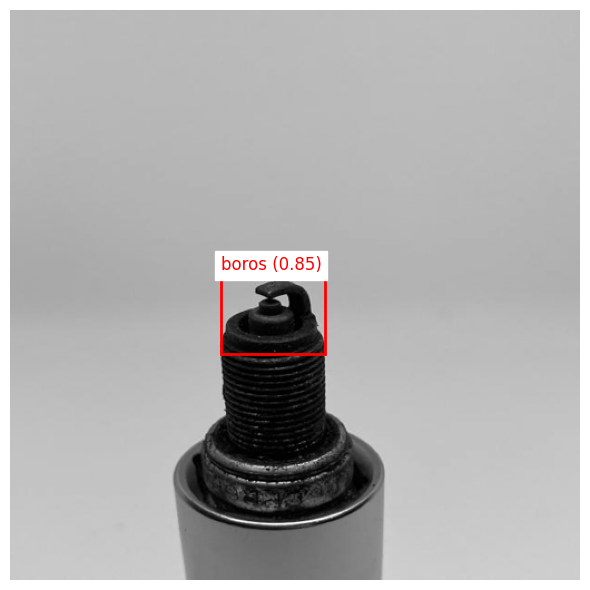

In [18]:
json_path = "../../data/detection/labeled/test/_annotations.coco.json"
img_dir = "../../data/detection/labeled/test"

with open(json_path) as f:
    data = json.load(f)

image_id = 0
img_info = next(img for img in data['images'] if img['id'] == image_id)
img_path = os.path.join(img_dir, img_info['file_name'])

img = Image.open(img_path).convert("L")
img_resized = img.resize((512, 512))



prediction = results[0]

if(prediction['score'] > 0.8):

    with open("../../model/label_mapping.json") as f:
        label_map = json.load(f)

    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.imshow(img_resized, cmap='gray')

    bbox = prediction['bbox']
    xmin, ymin, w, h = bbox
    rect = patches.Rectangle((xmin, ymin), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    label_id = str(prediction['category_id'])
    label_name = label_map.get(label_id, f"class {label_id}")
    score = prediction['score']
    ax.text(xmin, ymin - 5, f"{label_name} ({score:.2f})", color='red', fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [19]:
def convert(obj):
    if isinstance(obj, np.float32) or isinstance(obj, np.float64):
        return float(obj)
    elif isinstance(obj, list):
        return [convert(i) for i in obj]
    elif isinstance(obj, dict):
        return {k: convert(v) for k, v in obj.items()}
    else:
        return obj

converted_results = [convert(pred) for pred in results]

In [20]:
with open("../../model/predictions.json", "w") as f:
    json.dump(converted_results, f)

coco_dt = coco_gt.loadRes("../../model/predictions.json")
coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.params.imgIds = list(img_ids_used)
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

[0.90289164 0.16583003 0.11036368 0.107662   0.10391109 0.09832072
 0.08351994 0.07756707]


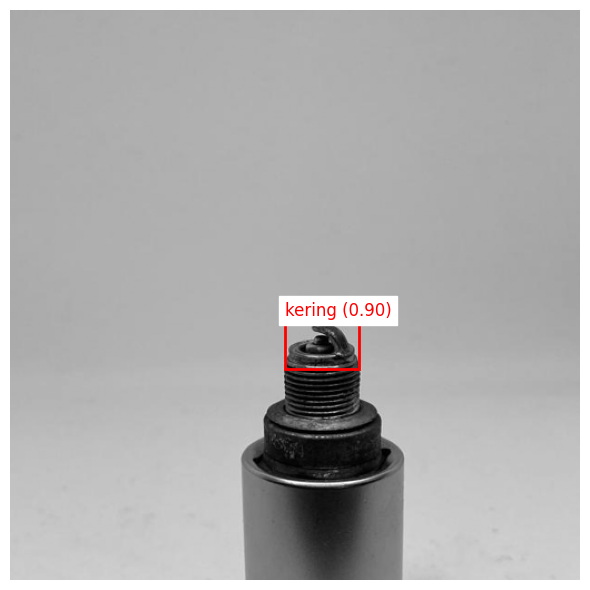

In [23]:
image_path = '../../data/detection/labeled/test/IMG_6934_JPG.rf.9489529cb44a0c61b8ac766c79e95819.jpg'
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor()
])

img = Image.open(image_path).convert("L")
img_resized = img.resize((512, 512))
img_tensor = transform(img_resized).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(img_tensor)

output = outputs[0]
boxes = output["boxes"].cpu().numpy()
scores = output["scores"].cpu().numpy()
labels = output["labels"].cpu().numpy()


fig, ax = plt.subplots(1, figsize=(8, 6))
ax.imshow(img_resized, cmap='gray')  
print(scores)
for box, score, label in zip(boxes, scores, labels):
    if score < 0.5:
        continue
    x_min, y_min, x_max, y_max = box
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    label_id = str(label)
    label_name = label_map.get(label_id, f"class {label_id}")
    ax.text(x_min, y_min - 5, f"{label_name} ({score:.2f})",
            color='red', fontsize=12, backgroundcolor='white')

plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
json_path = "../../data/detection/labeled/test/_annotations.coco.json"
img_dir = "../../data/detection/labeled/test"


with open(json_path) as f:
    data = json.load(f)

image_id = 0
img_info = next(img for img in data['images'] if img['id'] == image_id)
img_path = os.path.join(img_dir, img_info['file_name'])

img = Image.open(img_path).convert("L")

for result in results:

    prediction = result
    
    if(prediction['score'] > 0.8):

        with open("../../model/label_mapping.json") as f:
            label_map = json.load(f)

        fig, ax = plt.subplots(1, figsize=(8, 6))
        ax.imshow(img, cmap='gray')

        bbox = prediction['bbox']
        xmin, ymin, w, h = bbox
        rect = patches.Rectangle((xmin, ymin), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        label_id = str(prediction['category_id'])
        label_name = label_map.get(label_id, f"class {label_id}")
        score = prediction['score']
        ax.text(xmin, ymin - 5, f"{label_name} ({score:.2f})", color='red', fontsize=12, backgroundcolor='white')

        plt.axis('off')
        plt.tight_layout()
        plt.show()


In [39]:
ann_ids = coco_gt.getAnnIds()

annotations = coco_gt.loadAnns(ann_ids)

true_data = [{"image_id": ann["image_id"], "category_id": ann["category_id"]} for ann in annotations]

print(true_data)

[{'image_id': 0, 'category_id': 2}, {'image_id': 1, 'category_id': 1}, {'image_id': 2, 'category_id': 3}, {'image_id': 3, 'category_id': 2}, {'image_id': 4, 'category_id': 4}, {'image_id': 5, 'category_id': 1}, {'image_id': 6, 'category_id': 4}, {'image_id': 7, 'category_id': 4}, {'image_id': 8, 'category_id': 3}, {'image_id': 9, 'category_id': 4}, {'image_id': 10, 'category_id': 4}, {'image_id': 11, 'category_id': 3}, {'image_id': 12, 'category_id': 4}, {'image_id': 13, 'category_id': 1}, {'image_id': 14, 'category_id': 3}, {'image_id': 15, 'category_id': 2}, {'image_id': 16, 'category_id': 1}, {'image_id': 17, 'category_id': 3}, {'image_id': 18, 'category_id': 2}, {'image_id': 19, 'category_id': 3}, {'image_id': 20, 'category_id': 4}, {'image_id': 21, 'category_id': 1}, {'image_id': 22, 'category_id': 1}, {'image_id': 23, 'category_id': 3}, {'image_id': 24, 'category_id': 1}, {'image_id': 25, 'category_id': 3}, {'image_id': 26, 'category_id': 3}, {'image_id': 27, 'category_id': 3}, {

In [41]:
with open("../../model/predictions.json", "r") as f:
    predictions = json.load(f)

conf_pred = []
for prediction in predictions:
    
    found = next(
        (item for item in conf_pred if item["image_id"] == prediction['image_id'] and item["category_id"] == prediction['category_id']), None
    )
    

    if not found:
        conf_pred.append({
            "image_id": prediction['image_id'],
            "category_id": prediction['category_id'],
            "score": prediction['score']
        })
    else:
        for pred in conf_pred:
            if pred['image_id'] == prediction['image_id'] and prediction['score'] > pred['score']:
                pred['category_id'], pred['score'] = prediction['category_id'], prediction['score']
                print(f"data diganti dari cofidence {pred['score']} menjadi {prediction['score']}")
        continue

print(conf_pred)

[{'image_id': 0, 'category_id': 2, 'score': 0.8545804023742676}, {'image_id': 0, 'category_id': 1, 'score': 0.16903087496757507}, {'image_id': 0, 'category_id': 3, 'score': 0.10666129738092422}, {'image_id': 1, 'category_id': 1, 'score': 0.9747085571289062}, {'image_id': 1, 'category_id': 2, 'score': 0.08472195267677307}, {'image_id': 2, 'category_id': 3, 'score': 0.9165884852409363}, {'image_id': 2, 'category_id': 4, 'score': 0.2576807737350464}, {'image_id': 3, 'category_id': 2, 'score': 0.9521791934967041}, {'image_id': 3, 'category_id': 1, 'score': 0.11036369204521179}, {'image_id': 3, 'category_id': 3, 'score': 0.10766202956438065}, {'image_id': 3, 'category_id': 4, 'score': 0.10391110181808472}, {'image_id': 3, 'category_id': 5, 'score': 0.08351995050907135}, {'image_id': 4, 'category_id': 4, 'score': 0.9912973642349243}, {'image_id': 5, 'category_id': 2, 'score': 0.8816420435905457}, {'image_id': 5, 'category_id': 1, 'score': 0.31084349751472473}, {'image_id': 5, 'category_id': 

In [44]:
prediction_each_data = []
for data in true_data:
    for pred in conf_pred:
        found = next(
            (item for item in prediction_each_data if item["image_id"] == pred['image_id']), None
        )
        if pred['image_id'] == data['image_id'] and not found:
            prediction_each_data.append({
                "image_id": data['image_id'],
                "label": data['category_id'],
                "prediction": pred['category_id'],
                "score": pred['score']
            })


In [47]:
summary = {
    "true": 0,
    "false": 0
}

for data in prediction_each_data:
    if data['label'] == data['prediction']:
        summary['true'] += 1
    else:
        summary['false'] += 1

accuracy = summary['true'] / (summary['true'] + summary['false']) * 100
print(f"Akurasi: {"{:.2f}".format(accuracy)}%")

Akurasi: 87.67%


In [50]:
y_true = [d["label"] for d in prediction_each_data]
y_pred = [d["prediction"] for d in prediction_each_data]

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

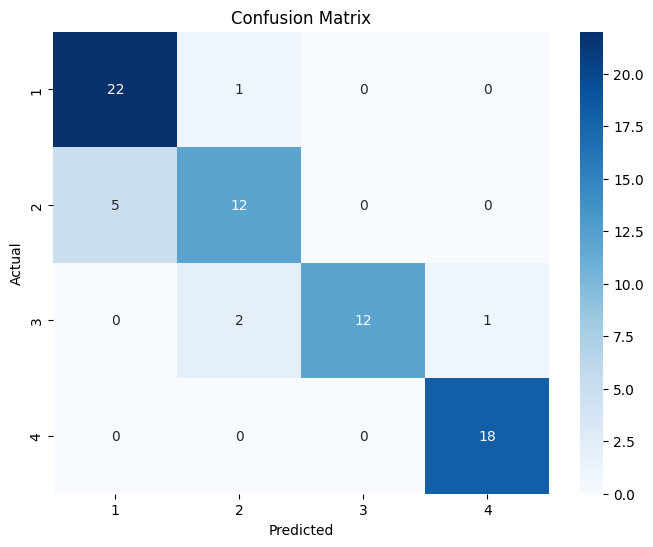

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = sorted(list(set(y_true + y_pred)))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred, labels=labels), annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()